In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import slippi
from slippi import Game
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss,accuracy_score, roc_curve, roc_auc_score
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

from ipywidgets import interact

pd.set_option('display.max_columns', None)


import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

from utils.data_utils import construct_df, ohe_chars_stage, characters, stages, stage_dict, construct_df_igs,\
                        process_df_igs, process_df_igs_final, make_rows_igs, get_ports, get_characters, get_winner
from utils.modeling_utils import plot_log_loss, plot_multiple_log_loss, CV_model, plot_feature_importances,\
                            plot_win_probs, get_log_losses, validate_model

import plotly.graph_objects as go


## Data Loading 

In [5]:
gs_5s_igs = pd.read_pickle('saved_data/gs_5s_igs.pkl')
fp9_5s_igs=pd.read_pickle('saved_data/fp9_5s_igs.pkl')
p2019_5s_igs = pd.read_pickle('saved_data/p2019_5s_igs.pkl')
nma2_5s_igs = pd.read_pickle('saved_data/nma2_5s_igs.pkl')
fb5_5s_igs=pd.read_pickle('saved_data/fb5_5s_igs.pkl')

In [6]:
df,features = process_df_igs_final(pd.concat([gs_5s_igs, fp9_5s_igs,p2019_5s_igs,nma2_5s_igs,fb5_5s_igs]).reset_index(drop=True))


In [8]:
drop_games = ['Game_20190309T155715', 'Game_20190309T160751']
df = df[~df['id'].isin(drop_games)]

In [187]:
df.to_pickle('saved_data/final_processed_data.pkl')

with open('saved_data/features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [145]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
X_train = df_train[features]
y_train = df_train['winner']

X_test = df_test[features]
y_test = df_test['winner']

## Fitting Model

In [ ]:
model = ExtraTreesClassifier(n_jobs=6, n_estimators=100, ccp_alpha=.000001,max_features=5, min_samples_split=4)

In [ ]:
model.fit(X_train,y_train)

In [16]:
with open('saved_data/final_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [4]:
model = pd.read_pickle('saved_data/final_model.pkl')

## Model Evaluation

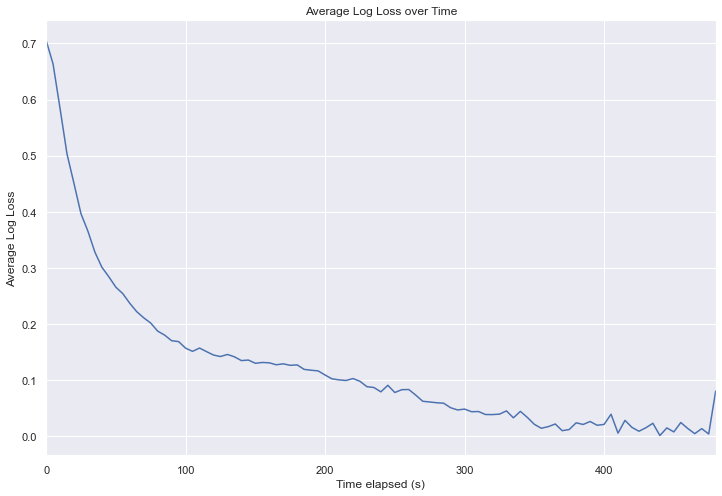

In [148]:
plot_log_loss(X_test,y_test,model,title = 'Average Log Loss over Time')

In [23]:
y_pred_prob = model.predict_proba(X_test)

In [24]:
log_loss(y_test, y_pred_prob)

0.25272844940864986

In [18]:
accuracy_score(y_test, model.predict(X_test))

0.9270488074348476

In [25]:
roc_auc_score(y_test, y_pred_prob[:,1])

0.9832704819571806

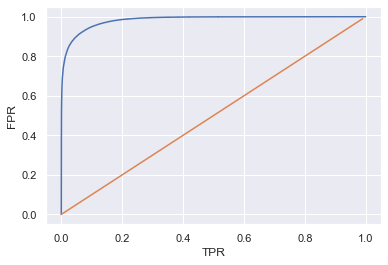

In [26]:
fpr, tpr, thresholds =roc_curve(y_test, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.show()

Looking at the above metrics, it does seem like the model performs well in an absolute sense. The Log loss curve looks pretty good, with a (relatively) low starting point of .7, which corresponds to an average of p=0.5 at the beginning, which is close to what I would want/expect. The average log loss of 0.25 is pretty good too, with that corresponding to an average p of 0.77 for the 1 class and 0.24. This is biased by the fact that there are more low times though, which means the average performance is better at later times, which can be seen in the graph. 

Accuracy is fairly high as well, which is always nice, but I'd caution looking too far into that. It's not really what I've been worrying about because the test points come from the same games as the train points, just at different times. I didn't want to just use a heldout set of games for the test set though because then many of the test points would be similar.

Of note is the very high ROC-AUC score. That shows the model is quite good at discriminating the two classes. This is probably a good thing, but it does make me wonder if this is reflected skewed predicted probabilities

In [143]:
win_calibration_df = pd.DataFrame(data = {'winner':y_test, 'predicted_prob':y_pred_prob[:,1]})
win_calibration_df['prob_bin']=pd.cut(win_calibration_df['predicted_prob'],np.arange(0,1,.01))
categories = win_calibration_df['prob_bin'].cat.categories
win_pct = win_calibration_df.groupby(['prob_bin'])['winner'].mean()
cal_df_mean = pd.DataFrame.from_records(list(zip(categories.right, win_pct)),columns=['tick','pct'])


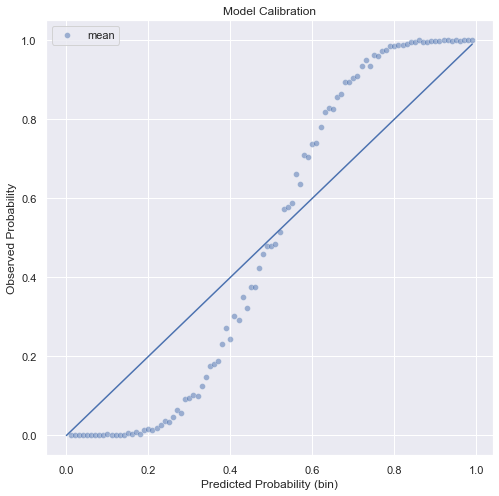

In [144]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=cal_df_mean,x='tick',y='pct',label='mean',alpha=0.5)
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.title('Model Calibration')
plt.xlabel('Predicted Probability (bin)')
plt.ylabel('Observed Probability')
plt.show()

This is pretty intersting - at first glance it might seem like the model isn't well calibrated, and I suppose maybe it isn't. This is telling us that if the model predicts that the odds p1 wins are 80%, really there's a >95% chance they win in practice. This means the model gives too much of a chance to people that are losing and too little of a chance to people who are winning. Obviously this isn't the best but given the fact that I want to show win probability graphs maybe its not too much of a bad thing. When I'm showing win probabilities the actual numbers down to the percent aren't as important as the overall trends in the game. 

With the ROC curve, I guess this means that the model is better at deciding whos winning than giving absolute odds.

After talking it over more I think that I could do some kind of inverse logistic transformation to get it to line up with the line. I'm not sure how that would affect the log loss or anything though.

I could also throw out all the points that it predicts will have an extremely low or high likelihood and retrain the model, though again not entirely sure if that would help.

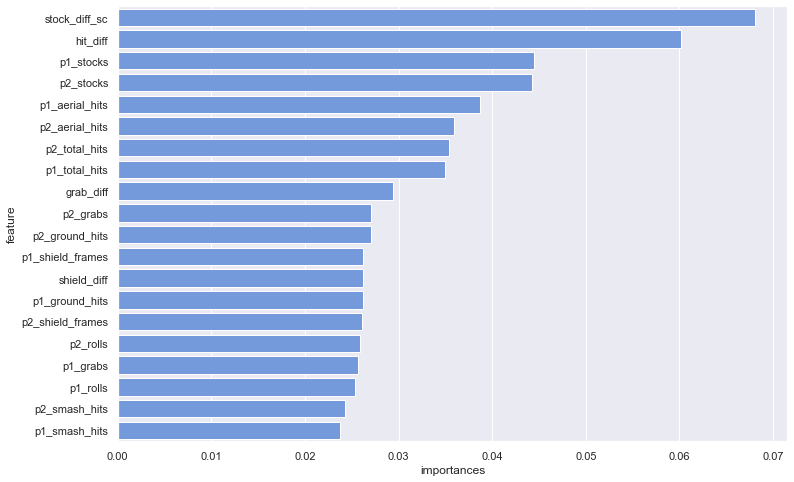

In [8]:
plot_feature_importances(model, features, 20)

## Smaller model for streamlit app

Unfortunately my model is quite large so in order to deploy it to a streamlit app I'm going to have to make some adjustments to its size and complexity to get it to fit on github.

In [96]:
X_train_streamlit = df_train[:len(df_train)//4][features].copy()
y_train_streamlit = df_train[:len(df_train)//4]['winner'].copy()

X_test_streamlit = df_test[:len(df_train)//4][features].copy()
y_test_streamlit = df_test[:len(df_train)//4]['winner'].copy()

In [109]:
streamlit_model = ExtraTreesClassifier(n_jobs=-1, max_depth=28, n_estimators=50, ccp_alpha=.000001,max_features=5, min_samples_split=4)
streamlit_model.fit(X_train_streamlit,y_train_streamlit)
#model = pd.read_pickle('saved_data/final_model.pkl')

ExtraTreesClassifier(ccp_alpha=1e-06, max_depth=28, max_features=5,
                     min_samples_split=4, n_estimators=50, n_jobs=-1)

In [110]:
with open('saved_data/streamlit_model.pkl', 'wb') as f:
    pickle.dump(streamlit_model, f)

In [111]:
y_pred_prob_s = streamlit_model.predict_proba(X_test_streamlit)

In [112]:
log_loss(y_test_streamlit, y_pred_prob_s)

0.4823178195687543

In [113]:
accuracy_score(y_test_streamlit, streamlit_model.predict(X_test_streamlit))

0.814760956984443

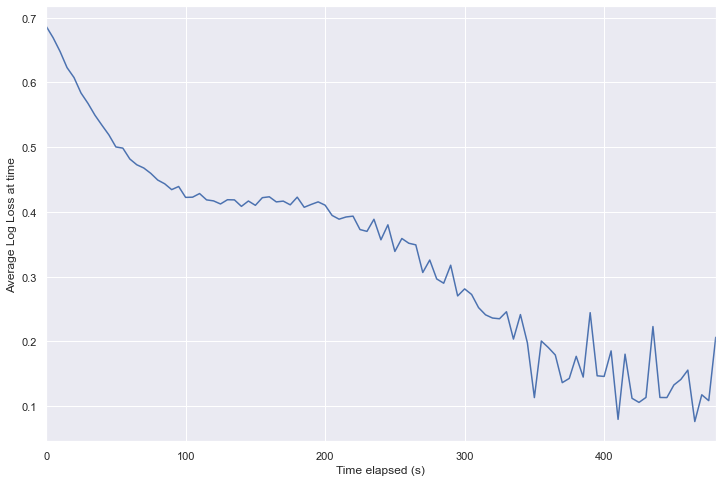

In [114]:
plot_log_loss(X_test,y_test,streamlit_model)

This new model's clearly not as good as the main model, but it is much smaller and will provide essentially the same functionality